# Demo of the pywst package

## 0. Presentation of the test maps

* Plot of three real intensity maps
* Plot of one complex polarization map

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.fits as fits
import os
import sys

In [2]:
sys.path.insert(0, os.path.abspath('..'))
import pywst as pw

In [3]:
mapsI = []
mapsI.append (fits.open('data/I_1.fits')[0].data)
mapsI.append (fits.open('data/I_2.fits')[0].data)
mapsI.append (fits.open('data/I_3.fits')[0].data)
mapsI = np.array(mapsI)

mapQiU = fits.open('data/Q_1.fits')[0].data + 1j * fits.open('data/U_1.fits')[0].data

In [4]:
def plot_axis(fig, ax, data, title='', colorbar=True):
    im = ax.imshow (data, cmap='jet', vmin=data.mean()-3*data.std (), vmax=data.mean()+3*data.std())
    ax.set_title(title)
    fig.colorbar(im, ax=ax)

<IPython.core.display.Javascript object>


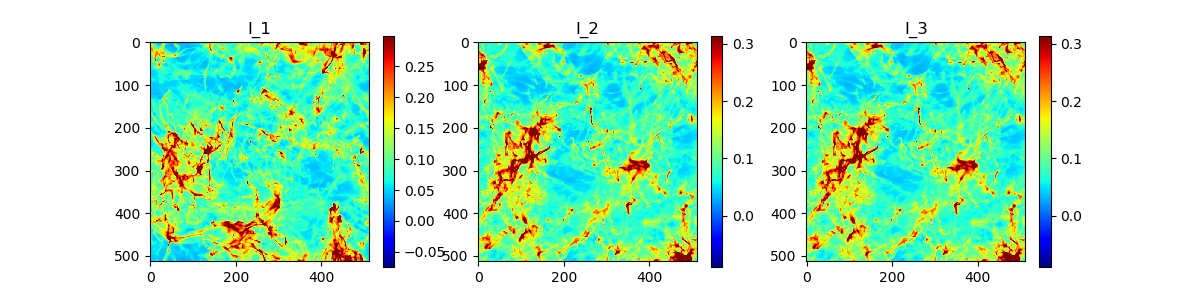

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
plot_axis(fig, axs[0], mapsI[0], "I_1")
plot_axis(fig, axs[1], mapsI[1], "I_2")
plot_axis(fig, axs[2], mapsI[1], "I_3")
plt.show()

<IPython.core.display.Javascript object>


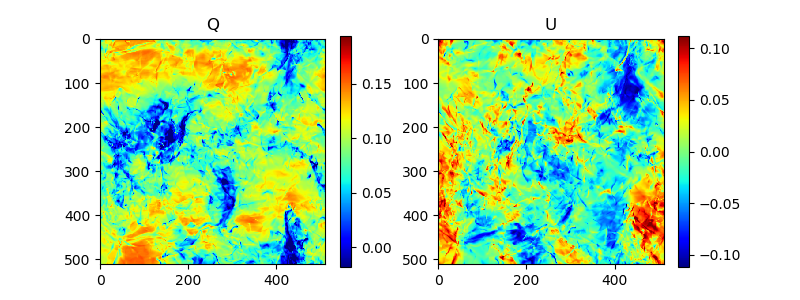

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
plot_axis(fig, axs[0], mapQiU.real, "Q")
plot_axis(fig, axs[1], mapQiU.imag, "U")
plt.show()

## 1. WST computation

* This section describes how to compute and plot WST of real and complex maps.
* Examples are first given when computing global WST statistics for one map, either real or complex.
* It is then shown how to compute and plot local WST coefficients, as well as WST statistics of several maps.

In [7]:
# We first define the global parameters of the WST transform
M, N = mapsI[0].shape # shapes of the maps on which the transform is applied
J = 7 # Number of dyadic scales of the transform
L = 8 # Number of angles in which the interval [0,pi] is divided
OS = 0 # OverSampling parameter, modifying the output of the transform for local computations

### 1.1. One real map, global WST
* Computation of the global WST of a real I intensity map
* Plot of the WST coefficients
* Normalization of the WST coefficients

In [ ]:
# We first define the WST operator with the global parameters previsously defined
# This operator then computes the WST of a real intensity map
wst_op = pw.WSTOp(M, N, J, L, OS)
wst = wst_op.apply(mapsI[0])

In [ ]:
# The output of the operator is a WST object from the WST class
type(wst)

In [ ]:
# Both m=1 and m=2 WST coefficients can be plotted by the "plot" method
# The results are given in (j1,t1) and (j1,t1,j2,t2) lexicographical orders
# For instance, the m=1 plot has J different j1 values, for which L angular values are used.
wst.plot()

# EA : Pourquoi c'est en linéaire et pas en log ici ? 

In [ ]:
# It is possible to normalize the m=n coefficients but those of m=n-1, using the "normalize" method
# We then plot the m=1 normalized WST coefficients
wst.normalize()
wst.plot(layer=1)

# EA : Peut-être rajouter ici comment checker si des WST sont normalized ou pas ?
# EA : On peut aller dans l'autre sens ? 


### 1.2. One complex map, global WST
* Computation of the global WST of a complex Q+iU polarization map
* Plot of the normalized WST coefficients
* Plot of the 2D angular dependency of the WST coefficients

<IPython.core.display.Javascript object>


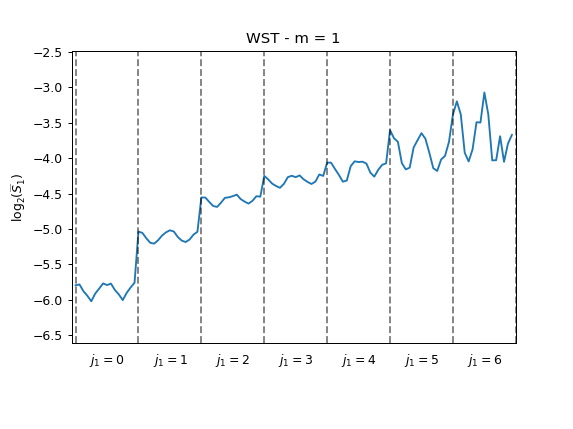

In [12]:
# We first define the WST operator for complex map
# We apply it to a complex Q+iU polarized map
# We then plot the normalize m=1 coefficients
# Note that those coefficients have 2L t1 values, since angles in [0,2pi] are considered
wst_op_cplx = pw.WSTOp(M, N, J, L, OS, cplx=True)
wst_cplx = wst_op_cplx.apply(mapQiU)
wst_cplx.normalize()
wst_cplx.plot(layer=1)

<IPython.core.display.Javascript object>


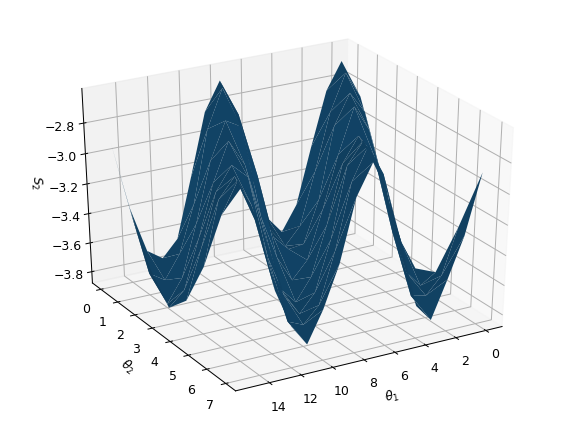

In [13]:
# We also plot the m=2 coefficients, at fixed j1 and j2 values, as a function of t1 and t2 
# For that purpose, we first select those coefficients, using the "get_coeffs" method
# EA : Si on veut garder cette commande en l'état, il faut clarifier l'utilisation de la selection des indices
# EA : ici ils sont traités en dur en prenant en compte l'ordre lexicographique ; c'est inutilisable pour les non-experts
# EA Par ailleurs, je ne suis pas sûr que ça apporte beaucoup pour la démo du soft, car c'est un plot qui ne sera pas utilisé
# EA : Il est présenté dans ton papier, et c'est bien, mais à réfléchir à ce qu'on en fait ici
# EA : J'arrête ici pour les commentaires de ce bloc
coeffs, index = wst_cplx.get_coeffs(layer=2, j1=2, j2=3)

coeffs = coeffs.reshape(2 * L, L)

from mpl_toolkits.mplot3d import Axes3D

X, Y = np.meshgrid(np.arange(2 * L), np.arange(L), indexing='ij')

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, coeffs)
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
ax.set_zlabel('$S_2$')
ax.view_init(30, 60)
plt.tight_layout()
plt.show()

### 1.3. One real map, local WST
* Computation of the local WST of a real intensity map
* Management of the boundary issues by cropping
* Averaging of the local coefficients

<IPython.core.display.Javascript object>


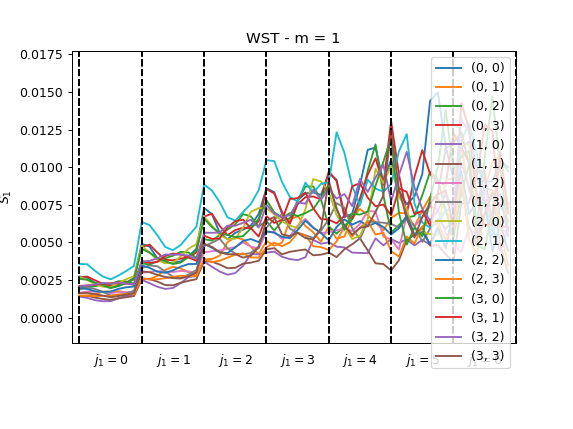

In [14]:
# The previous WST operator allows for local WST computations
# We then plot all local coefficients
wst = wst_op.apply(mapsI[0], local=True)
wst.plot(layer=1)

# Note than when a local WST transform is computed, the output of the transform is obtained
# by performing a subsampling at a 2^{J-OS} scale. For the present exemple, the size of the
# maps is 2^9, J=7, and OS=0. It implies that the spatial resolution of the output is 4x4.
# Thus, 16 local WST transforms are given in the present example.

<IPython.core.display.Javascript object>


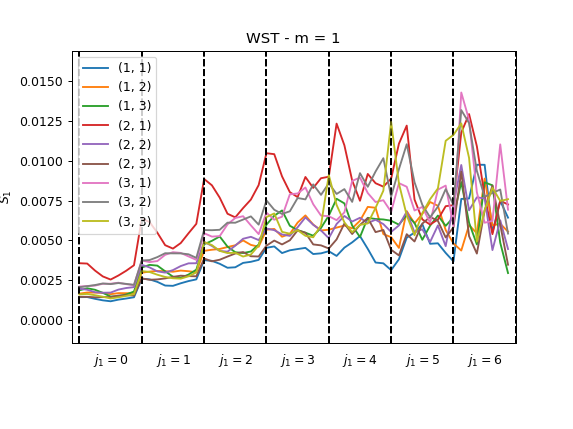

In [15]:
# When working with maps which don't have boundary periodic condition, it is necessary to 
# remove the local WST coefficient close to the boundary. This is done by using the "crop"
# option.
# EA : il faudra rajouter une description plus complète ici.
wst = wst_op.apply(mapsI[0], local=True, crop=1.0)
wst.plot(layer=1)

<IPython.core.display.Javascript object>


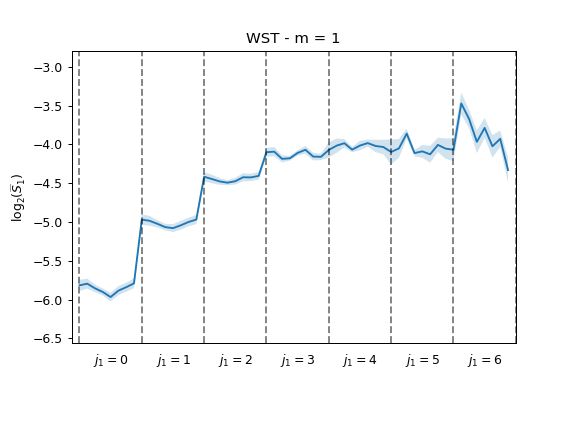

In [16]:
# It it possible to average the local WST coefficient to get global ones.
# This is done by the "average" method, here after a normalization step.
# Such a computation allows to estimate the errorbars of the WST coefficients
wst.normalize()
wst.average()
wst.plot(layer=1)

# EA : Est-ce qu'on veut permettre un calcul global direct avec des barres d'erreur ? 

### 1.4. Multiple real maps, global WST
* Computation of the global WST of a batch of real intensity maps

<IPython.core.display.Javascript object>


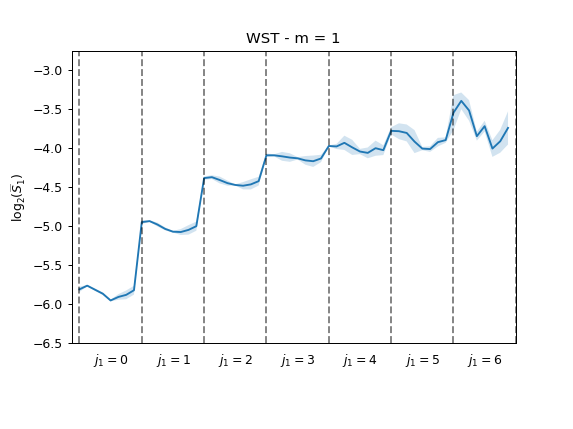

In [17]:
# The previous WST operator can also be applied to a batch of WST maps
# Here we average the results obtained
wst_batch = wst_op.apply(mapsI)
wst_batch.normalize()
wst_batch.average()
wst_batch.plot(layer=1)

# EA : C'est le même format pour local et batch ?
# EA : En tout cas c'est la même commande, ça ne peut pas porter à confusion ? 
# EA : Par exemple il se passe quoi si on fait du local en batch ?

# 2. RSWT computation


* This section describes how to compute and plot RWST coefficients
* This can be done from WST coefficients, or directly from a given map
* We also show how to change of RWST model

###  2.1. RWST computation from WST coefficients
* Computation of global RWST from a batch of global WST of a real intensity map

In [18]:
# We first define the RWST operator
# We then apply it to a batch of WST coefficients
rwst_op = pw.RWSTOp(M, N, J, L, wst_op=wst_op)
rwst_batch = rwst_op.apply(wst_batch)

# EA : Je pense qu'il n'est pas nécessaire de considérer la matrice de covariance par défaut. 
# EA : D'ailleurs, est-ce que tu l'as utilisée dans ton papier toi ?
# EA : Je mettrais son utilisation en option

/home/bruno/Bureau/These ENS/Outils/pywst/pywst/pywst/wst.py:318: UserWarning: Warning! Removing off diagonal coefficients of the sample covariance matrix (only 3 samples for dimension 8).
  warnings.warn("Warning! Removing off diagonal coefficients of the sample covariance matrix (only " + str(self.coeffs_cov_nbsamples) + " samples for dimension " + str(dim) + ").")
/home/bruno/Bureau/These ENS/Outils/pywst/pywst/pywst/wst.py:318: UserWarning: Warning! Removing off diagonal coefficients of the sample covariance matrix (only 3 samples for dimension 64).
  warnings.warn("Warning! Removing off diagonal coefficients of the sample covariance matrix (only " + str(self.coeffs_cov_nbsamples) + " samples for dimension " + str(dim) + ").")


<IPython.core.display.Javascript object>


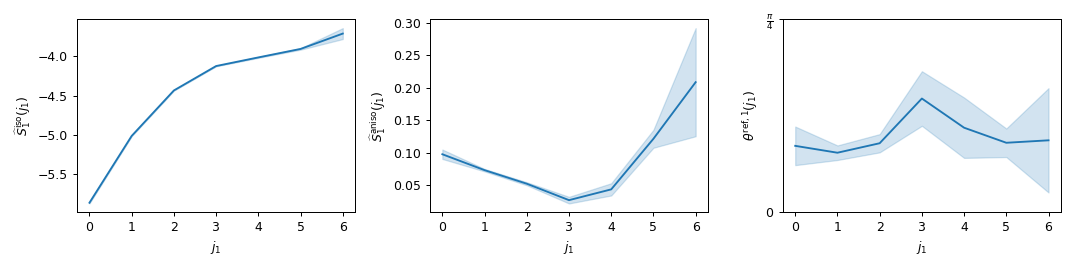

<IPython.core.display.Javascript object>


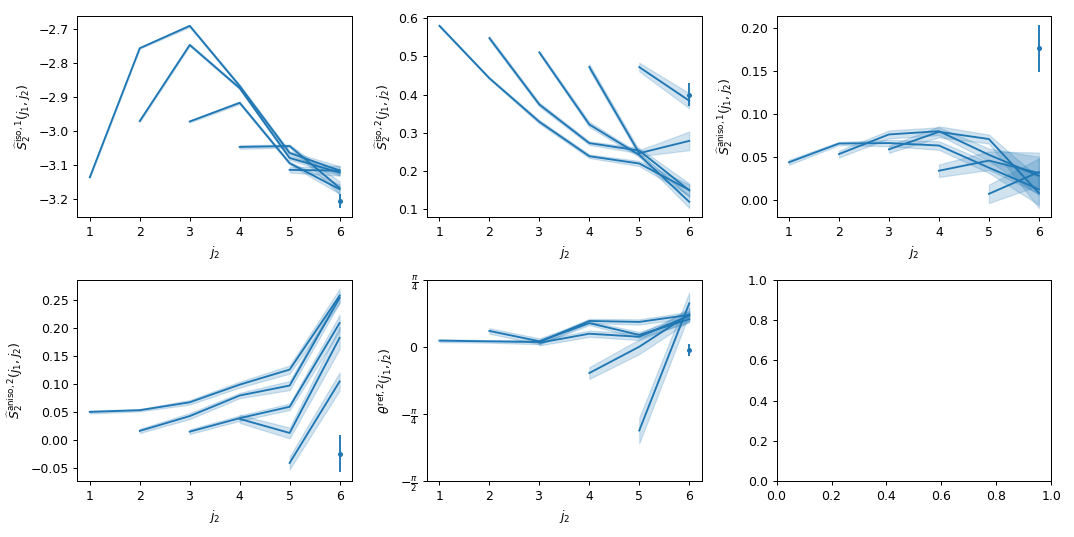

<IPython.core.display.Javascript object>


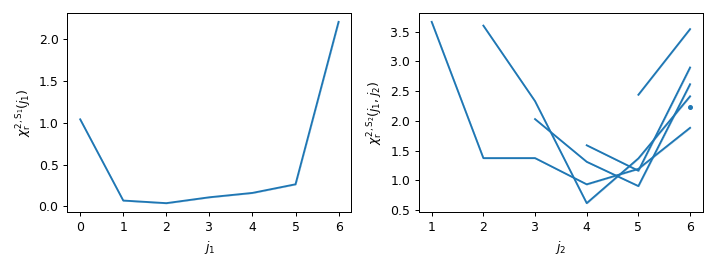

In [19]:
# It is possible to plot all the RWST coefficient with the "plot" method
rwst_batch.plot()

# EA : J'insisterais sur le fait que les chi^2 n'ont rien à faire ici
# EA : Par exemple il serait de mon point de vue pénible de l'avoir systématiquement
# une fois vérifié que les chi^2 sont ok
# EA : je le mettrais soit en option soit en séparé

### 2.2. RWST computation from maps
* Computation of local RWST forom a real intensity map

In [20]:
# The RWST operator previously defined can directly be applied to maps instead of WST coefficients
# Here we compute local RWST coefficients
rwst = rwst_op.apply(mapsI[0], local=True, crop=1.0)

# EA : pareil, je mettrais l'utilisation de la matrice de covariance en option

/home/bruno/Bureau/These ENS/Outils/pywst/pywst/pywst/wst.py:310: UserWarning: Warning! Covariance matrix is None.
  warnings.warn("Warning! Covariance matrix is None.")


In [21]:
# For each RWST layer, we can get the name of the different terms
print(rwst.model.layer1_names)

['S1Iso', 'S1Aniso', 'ThetaRef1']


In [22]:
# We can then get the coefficients of each RWST terms
print(rwst.get_coeffs("S1Aniso"))

# EA : ici c'est pas très clair comment les coefficients sont indiqués
# EA : Que sont ces différents tirets ? 
# EA : Ce serait peu-être mieux de mettre cet exemple plus haut, ou alors de ne sélectionner ici
# qu'un seul des coefficients locaux

[[[-- -- -- --]
  [-- 0.13971035702791856 0.01993269378957472 0.20773897100493485]
  [-- 0.24100576811387092 0.13769265185550106 0.06215224521973318]
  [-- 0.06838167758089889 0.06938993012128955 0.1245165415706282]]

 [[-- -- -- --]
  [-- 0.13811683093805122 0.017881140593920524 0.1910197629679052]
  [-- 0.2514802025072691 0.13158469198174655 0.07005298575654534]
  [-- 0.11370018297452456 0.08945263711632531 0.12367055008542721]]

 [[-- -- -- --]
  [-- 0.09848292933089045 0.07899997859262886 0.13982082616457295]
  [-- 0.22275192181124426 0.13483016984498414 0.08738530449092653]
  [-- 0.15872376103036553 0.0958936547077216 0.12765903588277716]]

 [[-- -- -- --]
  [-- 0.021683967031456843 0.10805491670795271 0.1576718835245603]
  [-- 0.17905287310630522 0.09132929699121953 0.10830427330526864]
  [-- 0.1889448360578993 0.14752324111052972 0.145355085491583]]

 [[-- -- -- --]
  [-- 0.2247298416058965 0.14099544131851502 0.16300579859066944]
  [-- 0.21829340773855918 0.09136523442316534 0.

<IPython.core.display.Javascript object>


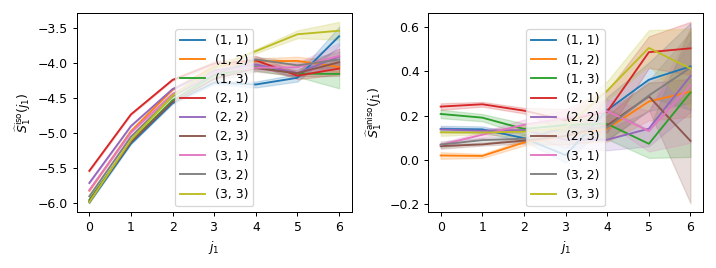

In [23]:
# We can also plot certain RWST terms
rwst.plot(["S1Iso", "S1Aniso"])

# EA : il faudrait gérer différemment l'affichage de la legend box

### 2.3. Changing the RWST model
* Change model
* Full plot
* Defining your own model

In [24]:
rwst_op_model2 = pw.RWSTOp(M, N, J, L, wst_op=wst_op, model=pw.RWSTModel2)
rwst = rwst_op_model2.apply(mapsI[0], local=True, crop=1.0)
print(rwst.model.layer1_names)

/home/bruno/Bureau/These ENS/Outils/pywst/pywst/pywst/wst.py:310: UserWarning: Warning! Covariance matrix is None.
  warnings.warn("Warning! Covariance matrix is None.")


['S1Iso', 'S1Aniso', 'ThetaRef1', 'S1Lat1', 'S1Lat2']


<IPython.core.display.Javascript object>


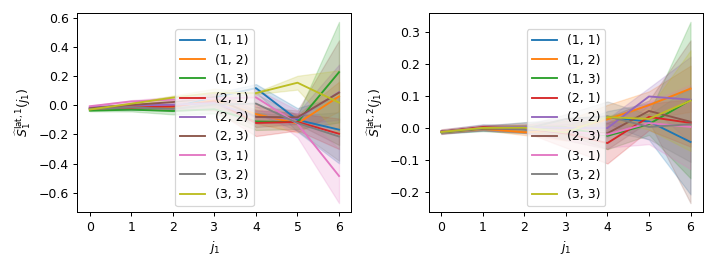

In [25]:
rwst.plot(['S1Lat1', 'S1Lat2'])

## 3. Comparison of (R)WST statistics

* Comparison of WST and its corresponding RWST model

* Comparison between RWSTs

<IPython.core.display.Javascript object>


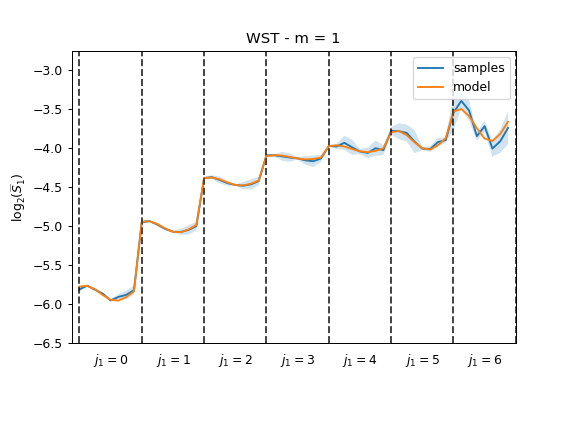

In [26]:
wst_batch.plot_compare(rwst_batch, layer=1, labels=['samples', 'model'])

/home/bruno/Bureau/These ENS/Outils/pywst/pywst/pywst/wst.py:310: UserWarning: Warning! Covariance matrix is None.
  warnings.warn("Warning! Covariance matrix is None.")


<IPython.core.display.Javascript object>


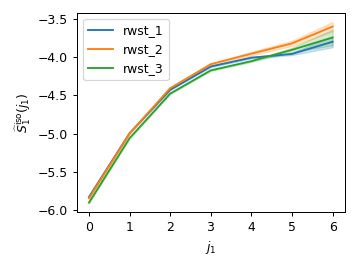

In [27]:
rwst_1 = rwst_op.apply(mapsI[0])
rwst_2 = rwst_op.apply(mapsI[1])
rwst_3 = rwst_op.apply(mapsI[2])

rwst_1.plot_compare([rwst_2, rwst_3], "S1Iso", labels=["rwst_1", "rwst_2", "rwst_3"])

## 4. Playing with filters

* Unit $L^1$-norm

In [28]:
def plot_filter(data):
    data = np.fft.fftshift(data) # Centering of the filter
    fig, axs = plt.subplots(1, 2, figsize=(10,3))
    plot_axis(fig, axs[0], data.real, "Real part")
    plot_axis(fig, axs[1], data.imag, "Imaginary part")
    plt.show()

### 4.1. Gaussian filters

Mean: 3.814697265625e-06 
L1-norm: 1.0


<IPython.core.display.Javascript object>


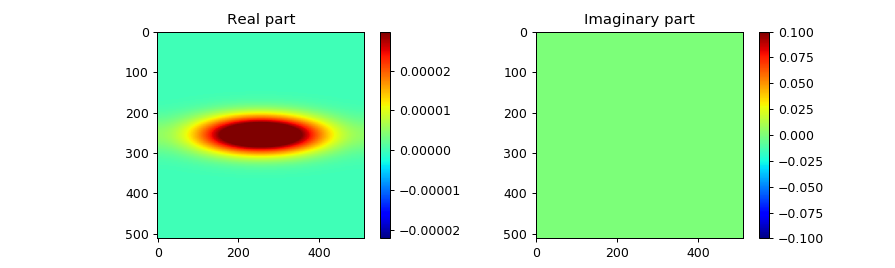

In [29]:
gaussian = pw.GaussianFilter(M, N, 5, gamma=0.3)
print ("Mean:", gaussian.data.mean(), "\nL1-norm:", np.sum(np.absolute(gaussian.data)))
plot_filter(gaussian.data)

### 4.2. Morlet wavelets

Mean: (-2.6469779601696886e-23-1.9025154088719637e-23j) 
L1-norm: 0.9785959280063218


<IPython.core.display.Javascript object>


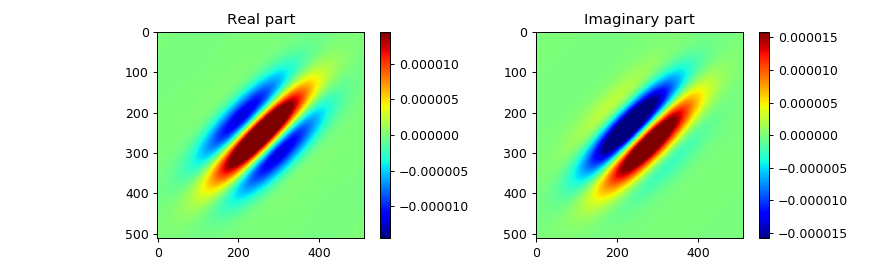

In [30]:
morlet = pw.MorletWavelet(M, N, 6, np.pi/4, 0.5, sigma0=0.8, k0=3*np.pi/4)
print("Mean:", morlet.data.mean(), "\nL1-norm:", np.sum(np.absolute(morlet.data)))
plot_filter(morlet.data)

### 4.3. Top-hat filters

Mean: 3.814697265625002e-06 
L1-norm: 1.0000000000000004


/home/bruno/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


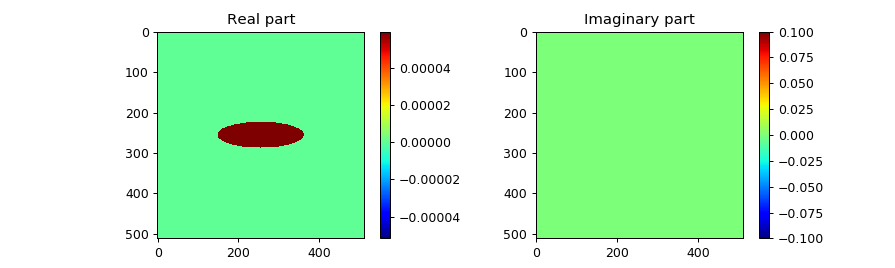

In [31]:
tophat = pw.TopHatFilter(M, N, 5, gamma=0.3)
print ("Mean:", tophat.data.mean(), "\nL1-norm:", np.sum(np.absolute(tophat.data)))
plot_filter(tophat.data)

### 4.4. Changing filters for your WST operator

In [32]:
#wst_op = pw.WSTOp(M, N, J, L, OS, lp_filter_cls=pw.GaussianFilter, bp_filter_cls=pw.MorletWavelet)